In [38]:
# Set up libraries and backend
from qiskit.tools.jupyter import * 
from qiskit import IBMQ
from qiskit import assemble
import numpy as np
import matplotlib.pyplot as plt
from qiskit import pulse
from qiskit import pulse
from qiskit.pulse import Play
from qiskit.tools.monitor import job_monitor
from scipy.optimize import curve_fit
import json

%config InlineBackend.figure_format = 'svg'
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support OpenPulse"

# Use for conversions later
GHz = 1.0e9
MHz = 1.0e6
kHz = 1.0e3
ms = 1.0e-3
us = 1.0e-6
ns = 1.0e-9
scale_factor = 1e-14

# Initialize qubit to |0> and retrieve backend frequencies
qubit = 0
dt = backend_config.dt
backend_defaults = backend.defaults()
qubit_props_dict = backend.properties().qubit_property(0)
rough_qubit_freq = qubit_props_dict['frequency'][0]
rough_cav_freq = backend_defaults.meas_freq_est[qubit]


# Define and configure measurement map (hardware constraint)
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in meas_map!"
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)
qubit_meas_group = backend_config.meas_map[meas_map_idx]
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=qubit_meas_group)


# Define for convenience
def get_closest_multiple_of_16(num):
     return int(num + 8) - (int(num + 8) % 16)

# Functions to save data to and load data from external text files
def saveData(dataset, file):
    filehandler = open(file, 'w')
    json.dump(dataset, filehandler)
    filehandler.close()
    
def loadData(file):
    filehandler = open(file)
    data = json.load(filehandler)
    filehandler.close()
    return data

def get_job_data(job):
    result = job.result(timeout=120)
    sweep = []
    for i in range(len(result.results)):
        res = result.get_memory(i)*scale_factor
        sweep.append(res[qubit])
    return sweep

# Define curve fitting function
def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params, maxfev=5000)
    y_fit = function(x_values, *fitparams)
    return fitparams, y_fit

ibmqfactory.load_account:WARNING:2020-12-31 08:23:19,786: Credentials are already in use. The existing account in the session will be replaced.


In [39]:
def composite_gaussian_square(channel, duration, amp, sigma, width, chunking): 
    comp_pulse = pulse.Schedule(name='a')
    samples = pulse.GaussianSquare(duration, amp, sigma, width).get_waveform().samples
    risefall = get_closest_multiple_of_16((duration - width)//2)
    rise = pulse.Waveform(samples[:risefall])
    fall = pulse.Waveform(samples[risefall+width:])
    constant = pulse.Constant(chunking, amp)
    # remainder = pulse.Constant(width % chunking, amp)
    comp_pulse += pulse.Play(rise, channel)
    for i in range(width//chunking):
        comp_pulse += pulse.Play(constant, channel)
    # comp_pulse += pulse.Play(remainder, channel) --> do not play this pulse because it won't be right cycle multiple
    comp_pulse += pulse.Play(fall, channel)
    return comp_pulse

In [40]:
sigma_us = 0.01 # stdev of Gaussian square pulses
risefall_us = 0.02 # risefall time of Gaussian square pulses
gap_us = 0.1 # gap btwn last pulse in a schedule and acq window: I was getting internal error 9999 w/o a gap

sigma = get_closest_multiple_of_16(sigma_us * us/dt)
risefall = get_closest_multiple_of_16(risefall_us * us/dt)
gap = get_closest_multiple_of_16(gap_us * us/dt)

max_chunk = 2048 # number of cycles that pulse is chunked into
num_shots = 1024

cavity_data = loadData('CavityParameters.txt') # data from other experiments
cav_freq_Hz = cavity_data['wc']
disp_Hz = cavity_data['X']
cav_freq_Hz_g = cav_freq_Hz + disp_Hz
cav_freq_GHz_g = cav_freq_Hz_g / GHz
print(cav_freq_Hz, cav_freq_Hz_g, rough_cav_freq)

qubit_data = loadData('QubitFrequency.txt')
mod_qubit_freq_Hz = qubit_data['wq'] # Value from experiment

schedule_freqs = {drive_chan: mod_qubit_freq_Hz, meas_chan: cav_freq_Hz_g}

pi_data = loadData('pipulse.txt') # from calibration experiment
drive_samps_us = pi_data['drive_samps_us'] # Width of the gaussian pulse
drive_sigma_us = pi_data['drive_sigma_us'] # Truncates duration of gaussian to be finite
pi_amp = pi_data['pi_amp']

drive_samps = get_closest_multiple_of_16(drive_samps_us * us/dt) # Puts width in units of dt
drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us/dt) # Puts duration in units of dt

pi_pulse = pulse.Gaussian(drive_samps, pi_amp, drive_sigma)

6993419623.685421 6993440719.492953 6993427855.0


In [41]:
# here we are trying to find  T1 as function of cavity drive pulse strength (vary amp)
min_amp_v1_1 = 0.0 
max_amp_v1_1 = 0.4
min_amp_v1_2 = 0.5
max_amp_v1_2 = 0.9
num_amps = 5
amps_v1_1 = np.linspace(min_amp_v1_1, max_amp_v1_1, num_amps, endpoint=True) # first half of amplitudes
amps_v1_2 = np.linspace(min_amp_v1_2, max_amp_v1_2, num_amps, endpoint=True) # second half

acq_time_us_v1 = 0.5 # small acquisition time gives more reliable results
num_trials_v1 = 3 # avg T1 decay curves over several trials due to noise

min_time_us_v1 = 5 # times over which T1 decay is measuredd
max_time_us_v1 = 300 
num_times_v1 = 75
times_us_v1 = np.linspace(min_time_us_v1, max_time_us_v1, num_times_v1, endpoint=True) # times array

In [42]:
# define function for recording cavity quadratures over time array, with qb in ground state
def run_gs_sweep_v1(times_us, amp_array, acq_time_us, num_trials): 
    
    acq_samp = get_closest_multiple_of_16(acq_time_us * us/dt)
    acq_pulse = pulse.Acquire(acq_samp, pulse.AcquireChannel(qubit), 
                          mem_slot=pulse.MemorySlot(qubit)) # define acq pulse
    meas_width = acq_samp - 2 * risefall
        
    times = [get_closest_multiple_of_16(time_us * us/dt) for time_us in times_us]
        
    total_sweeps = []
    for i in range(num_trials):
        amp_jobs = []
    
        for amp in amp_array:
            # for meas pulse, use same pulse amplitude as drive pulse for continuity (small amp when there is no pulse)

            if (amp == 0.0):
                meas_pulse = pulse.GaussianSquare(acq_samp, 0.1, sigma, meas_width)  
            else: 
                meas_pulse = pulse.GaussianSquare(acq_samp, amp, sigma, meas_width) 
            
            meas_schedule = pulse.Schedule(name='Measurement schedule')
            meas_schedule += Play(meas_pulse, meas_chan)
            meas_schedule += acq_pulse
        
            # standard quadrature measurement experiment
            gs_schedules = []
            for delay in times:
                this_schedule = pulse.Schedule(name=f"T1 delay = {delay * dt/us} us")
            
                if (amp == 0.0):
                    this_schedule += meas_schedule << (delay + gap)
                
                else:
                    this_width = delay - 2 * risefall
                    this_pulse = composite_gaussian_square(meas_chan, delay, amp, sigma, this_width, max_chunk)
                    this_schedule += this_pulse
                    this_schedule += meas_schedule << gap
                
                gs_schedules.append(this_schedule)
    
            gs_experiment = assemble(gs_schedules,
                                 backend=backend, 
                                 meas_level=1,
                                 meas_return='avg',
                                 shots=num_shots,
                                 schedule_los=schedule_freqs)
    
            amp_job = backend.run(gs_experiment)
            print(f"Job for amp = {amp} in trial {i+1}")
            amp_jobs.append(amp_job)
        
        print(f"Status of last job in trial {i+1}:")
        job_monitor(amp_jobs[-1])
    
        # store data 
        amp_sweeps = []
        for job in amp_jobs:
            sweep = get_job_data(job)
            
            mid_index = len(sweep) // 2
            last_val_real = np.real(sweep[-1])
            mid_val_real = np.real(sweep[mid_index])
            if (last_val_real > mid_val_real):
                sweep = np.negative(sweep)            
            
            amp_sweeps.append(sweep)
        
        total_sweeps.append(amp_sweeps)
    
    # get avg over all trials. IGNORE THIS METHOD IIN BOTH GS AND ES FUNCTIONS, DID NOT END UP WORKING
    # I take the average data a bit more manually later
    sum_location = np.array([[0+0j] * len(times_us) for i in range(len(amp_array))])
    for i in range(num_trials):
        one_trial_data = np.array(total_sweeps[i])
        sum_location += one_trial_data
    avg_data = sum_location / num_trials
    
    return avg_data, total_sweeps

In [43]:
# similar protocol for exc state, only difference is we apply qb pi pulse before cav drive pulse
def run_es_sweep_v1(times_us, amp_array, acq_time_us, num_trials):
    
    acq_samp = get_closest_multiple_of_16(acq_time_us * us/dt)
    acq_pulse = pulse.Acquire(acq_samp, pulse.AcquireChannel(qubit), 
                          mem_slot=pulse.MemorySlot(qubit)) # define acq pulse
    meas_width = acq_samp - 2 * risefall
        
    times = [get_closest_multiple_of_16(time_us * us/dt) for time_us in times_us]
        
    total_sweeps = []
    for i in range(num_trials):
        amp_jobs = []
    
        for amp in amp_array:
            if (amp == 0.0):
                meas_pulse = pulse.GaussianSquare(acq_samp, 0.1, sigma, meas_width) # 0.1
            else: 
                meas_pulse = pulse.GaussianSquare(acq_samp, amp, sigma, meas_width) # amp
            
            meas_schedule = pulse.Schedule(name='Measurement schedule')
            meas_schedule += Play(meas_pulse, meas_chan)
            meas_schedule += acq_pulse
        
            es_schedules = []
            for delay in times:
                this_schedule = pulse.Schedule(name=f"T1 delay = {delay * dt/us} us")
                this_schedule += Play(pi_pulse, drive_chan)
            
                if (amp == 0.0):
                    this_schedule += meas_schedule << (pi_pulse.duration + delay + gap)
                
                else:
                    this_width = delay - 2 * risefall
                    this_pulse = composite_gaussian_square(meas_chan, delay, amp, sigma, this_width, max_chunk)
                    this_schedule += this_pulse << pi_pulse.duration
                    this_schedule += meas_schedule << gap
                
                es_schedules.append(this_schedule)
    
            es_experiment = assemble(es_schedules,
                                 backend=backend, 
                                 meas_level=1,
                                 meas_return='avg',
                                 shots=num_shots,
                                 schedule_los=schedule_freqs)
    
            amp_job = backend.run(es_experiment)
            print(f"Job for amp = {amp} in trial {i+1}")
            amp_jobs.append(amp_job)
        
        print(f"Status of last job in trial {i+1}:")
        job_monitor(amp_jobs[-1])
    
        amp_sweeps = []
        for job in amp_jobs:
            sweep = get_job_data(job)
            
            mid_index = len(sweep) // 2
            last_val_real = np.real(sweep[-1])
            mid_val_real = np.real(sweep[mid_index])
            if (last_val_real > mid_val_real):
                sweep = np.negative(sweep) 
                
            amp_sweeps.append(sweep)
        
        total_sweeps.append(amp_sweeps)
    
    sum_location = np.array([[0+0j] * len(times_us) for i in range(len(amp_array))])
    for i in range(num_trials):
        one_trial_data = np.array(total_sweeps[i])
        sum_location += one_trial_data
    avg_data = sum_location / num_trials
    
    return avg_data, total_sweeps

In [ ]:
# we run ground and exc state experiments for both sets of amp arrays

In [44]:
gs_jobs_v1_1 = run_gs_sweep_v1(times_us_v1, amps_v1_1, acq_time_us_v1, num_trials_v1)

Job for amp = 0.0 in trial 1
Job for amp = 0.1 in trial 1
Job for amp = 0.2 in trial 1
Job for amp = 0.30000000000000004 in trial 1
Job for amp = 0.4 in trial 1
Status of last job in trial 1:
Job Status: job has successfully run
Job for amp = 0.0 in trial 2
Job for amp = 0.1 in trial 2
Job for amp = 0.2 in trial 2
Job for amp = 0.30000000000000004 in trial 2
Job for amp = 0.4 in trial 2
Status of last job in trial 2:
Job Status: job has successfully run
Job for amp = 0.0 in trial 3
Job for amp = 0.1 in trial 3
Job for amp = 0.2 in trial 3
Job for amp = 0.30000000000000004 in trial 3
Job for amp = 0.4 in trial 3
Status of last job in trial 3:
Job Status: job has successfully run


In [53]:
min_y_val = -10
max_y_val = 10
step_y_val = 1
ticks = np.arange(min_y_val, max_y_val, step_y_val)

In [51]:
gs_jobs_v1_2 = run_gs_sweep_v1(times_us_v1, amps_v1_2, acq_time_us_v1, num_trials_v1)

Job for amp = 0.5 in trial 1
Job for amp = 0.6 in trial 1
Job for amp = 0.7 in trial 1
Job for amp = 0.8 in trial 1
Job for amp = 0.9 in trial 1
Status of last job in trial 1:
Job Status: job has successfully run
Job for amp = 0.5 in trial 2
Job for amp = 0.6 in trial 2
Job for amp = 0.7 in trial 2
Job for amp = 0.8 in trial 2
Job for amp = 0.9 in trial 2
Status of last job in trial 2:
Job Status: job has successfully run
Job for amp = 0.5 in trial 3
Job for amp = 0.6 in trial 3
Job for amp = 0.7 in trial 3
Job for amp = 0.8 in trial 3
Job for amp = 0.9 in trial 3
Status of last job in trial 3:
Job Status: job has successfully run


In [55]:
es_jobs_v1_1 = run_es_sweep_v1(times_us_v1, amps_v1_1, acq_time_us_v1, num_trials_v1)

Job for amp = 0.0 in trial 1
Job for amp = 0.1 in trial 1
Job for amp = 0.2 in trial 1
Job for amp = 0.30000000000000004 in trial 1
Job for amp = 0.4 in trial 1
Status of last job in trial 1:
Job Status: job has successfully run
Job for amp = 0.0 in trial 2
Job for amp = 0.1 in trial 2
Job for amp = 0.2 in trial 2
Job for amp = 0.30000000000000004 in trial 2
Job for amp = 0.4 in trial 2
Status of last job in trial 2:
Job Status: job has successfully run
Job for amp = 0.0 in trial 3
Job for amp = 0.1 in trial 3
Job for amp = 0.2 in trial 3
Job for amp = 0.30000000000000004 in trial 3
Job for amp = 0.4 in trial 3
Status of last job in trial 3:
Job Status: job has successfully run


In [60]:
es_jobs_v1_2 = run_es_sweep_v1(times_us_v1, amps_v1_2, acq_time_us_v1, num_trials_v1)

Job for amp = 0.5 in trial 1
Job for amp = 0.6 in trial 1
Job for amp = 0.7 in trial 1
Job for amp = 0.8 in trial 1
Job for amp = 0.9 in trial 1
Status of last job in trial 1:
Job Status: job has successfully run
Job for amp = 0.5 in trial 2
Job for amp = 0.6 in trial 2
Job for amp = 0.7 in trial 2
Job for amp = 0.8 in trial 2
Job for amp = 0.9 in trial 2
Status of last job in trial 2:
Job Status: job has successfully run
Job for amp = 0.5 in trial 3
Job for amp = 0.6 in trial 3
Job for amp = 0.7 in trial 3
Job for amp = 0.8 in trial 3
Job for amp = 0.9 in trial 3
Status of last job in trial 3:
Job Status: job has successfully run


In [ ]:
# record full trial data

In [73]:
tot_gs_data_v1_1 = gs_jobs_v1_1[1]
tot_gs_data_v1_2 = gs_jobs_v1_2[1]
tot_es_data_v1_1 = es_jobs_v1_1[1]
tot_es_data_v1_2 = es_jobs_v1_2[1]

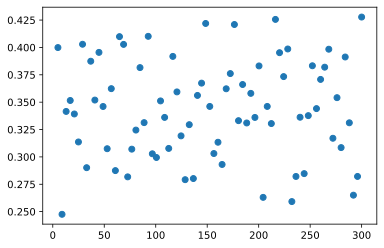

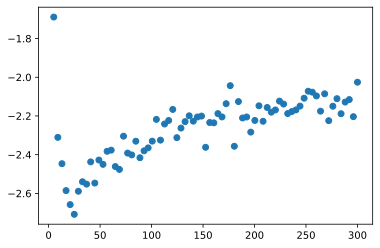

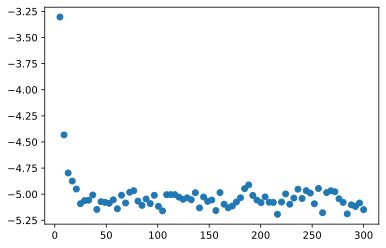

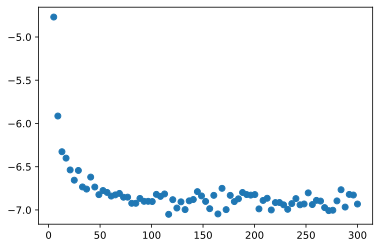

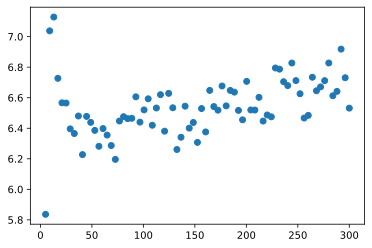

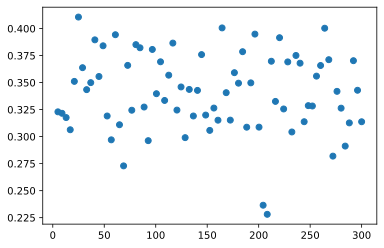

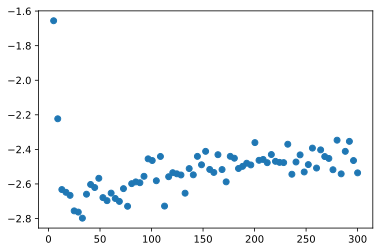

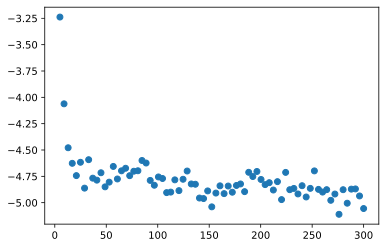

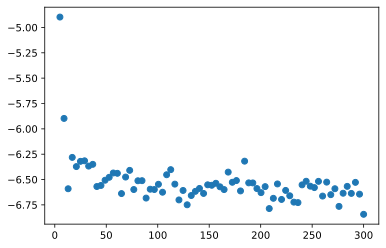

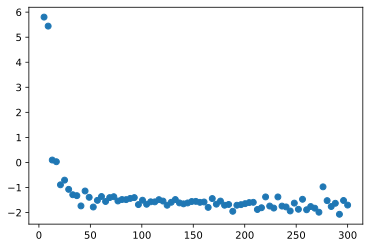

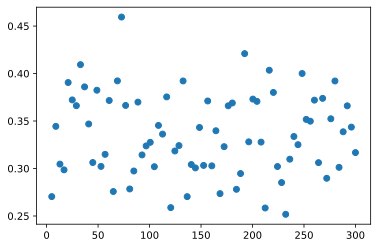

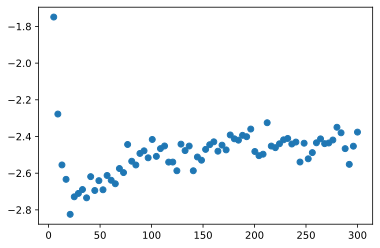

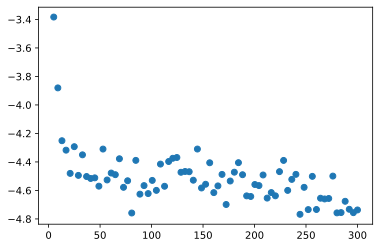

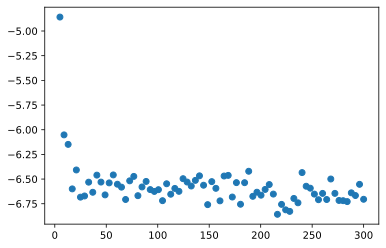

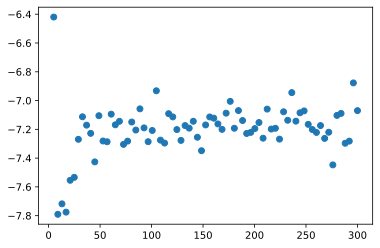

In [99]:
# modify trial data by making sure decay data all 'points' the same way.
mod_gs_data_v1_1 = []

for sample in tot_gs_data_v1_1:
    trial_samp = []
    for sweep in sample:
        if (sweep[0] < sweep[1]) or (sweep[1] < sweep[-1]):
            sweep = np.negative(sweep)
        trial_samp.append(sweep)
    mod_gs_data_v1_1.append(trial_samp)
    
for a in mod_gs_data_v1_1:
    for b in a:
        plt.scatter(times_us_v1, b)
        plt.show()

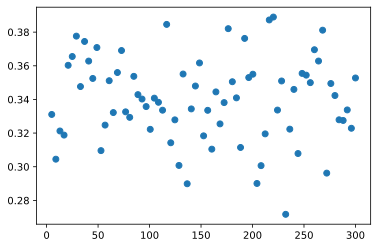

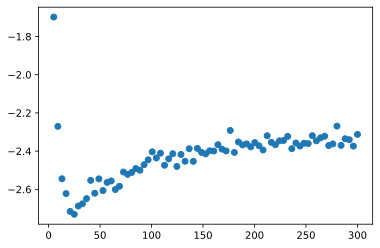

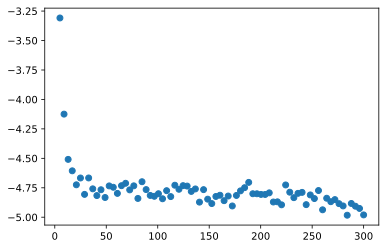

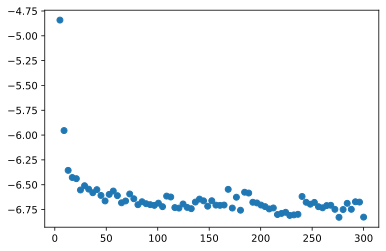

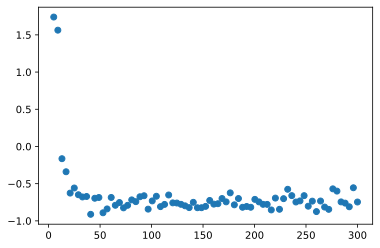

In [101]:
# take average over modified data and plot to make sure it looks coherent
mod_avg_gs_data_v1_1 = np.array([[0+0j] * len(times_us_v1) for i in range(len(amps_v1_1))])
for i in range(len(mod_gs_data_v1_1)):
    mod_avg_gs_data_v1_1 += np.array(mod_gs_data_v1_1[i])
mod_avg_gs_data_v1_1 = mod_avg_gs_data_v1_1 / num_trials_v1

for i in mod_avg_gs_data_v1_1:
    plt.scatter(times_us_v1, i)
    plt.show()

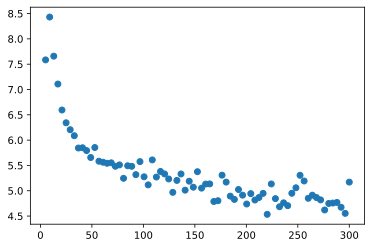

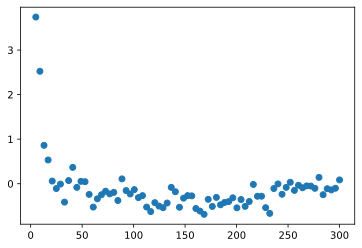

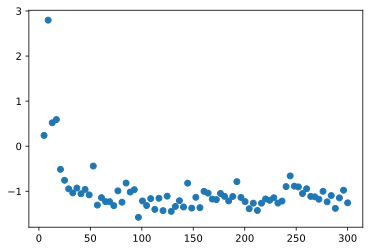

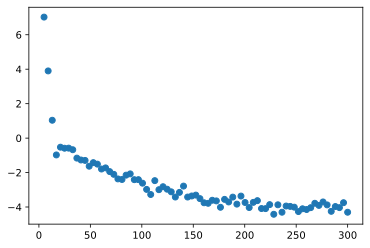

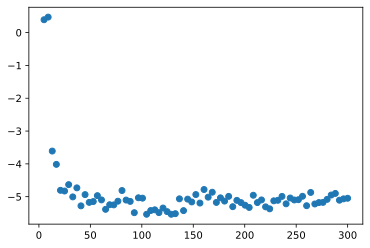

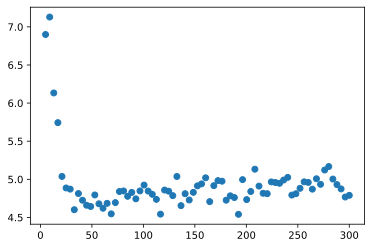

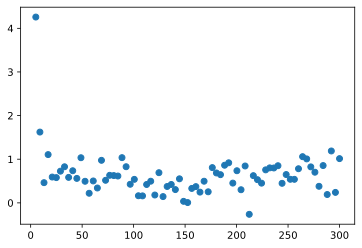

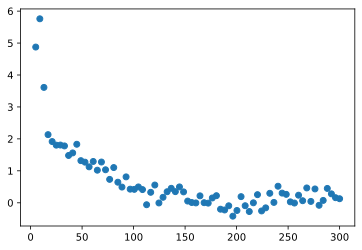

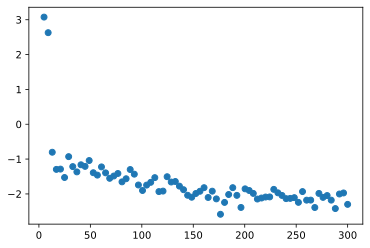

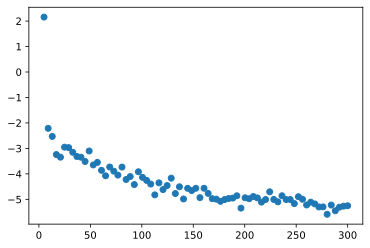

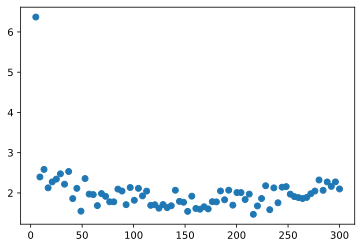

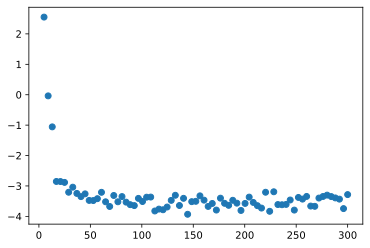

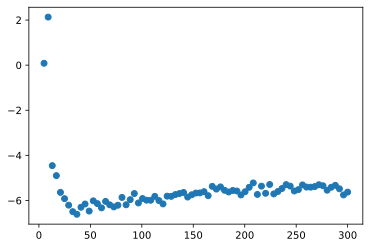

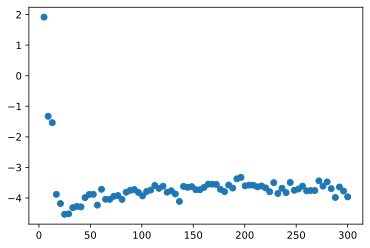

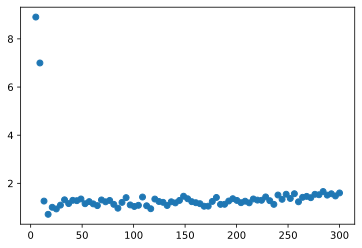

In [103]:
# similar process for the rest of the data
mod_gs_data_v1_2 = []

for sample in tot_gs_data_v1_2:
    trial_samp = []
    for sweep in sample:
        if (sweep[1] < sweep[-1]):
            sweep = np.negative(sweep)
        trial_samp.append(sweep)
    mod_gs_data_v1_2.append(trial_samp)
    
for a in mod_gs_data_v1_2:
    for b in a:
        plt.scatter(times_us_v1, b)
        plt.show()

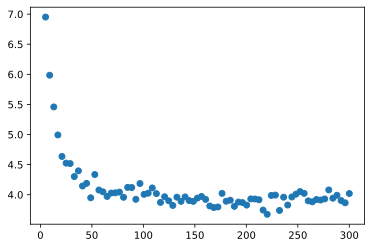

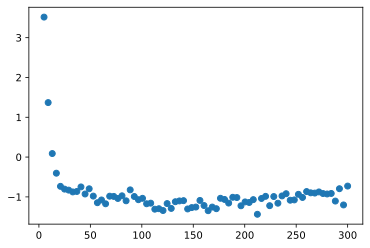

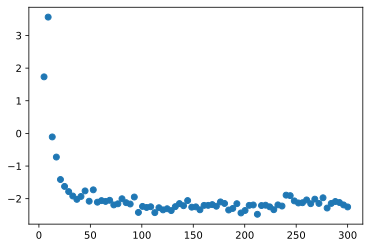

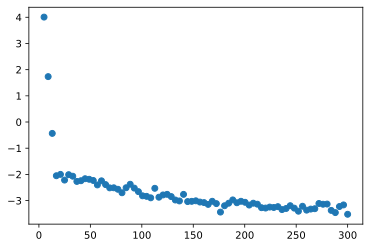

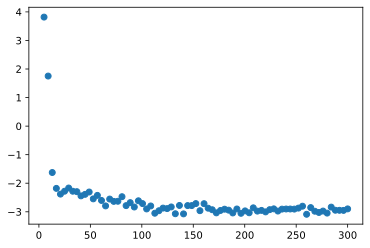

In [104]:
mod_avg_gs_data_v1_2 = np.array([[0+0j] * len(times_us_v1) for i in range(len(amps_v1_1))])
for i in range(len(mod_gs_data_v1_2)):
    mod_avg_gs_data_v1_2 += np.array(mod_gs_data_v1_2[i])
mod_avg_gs_data_v1_2 = mod_avg_gs_data_v1_2 / num_trials_v1

for i in mod_avg_gs_data_v1_2:
    plt.scatter(times_us_v1, i)
    plt.show()

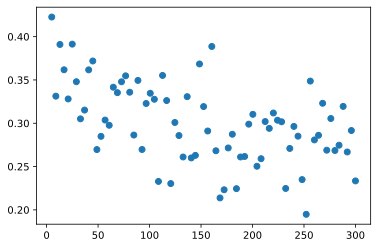

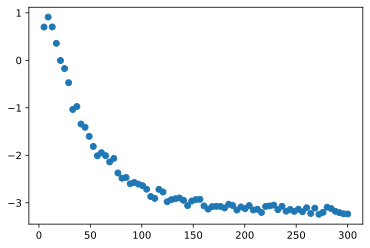

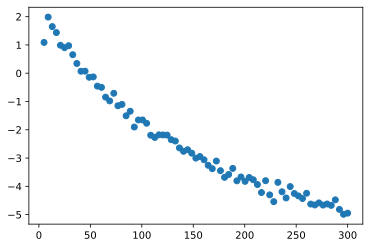

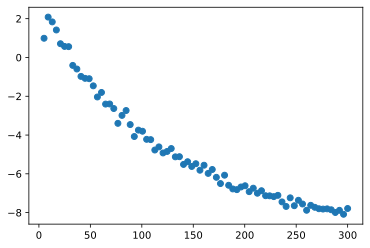

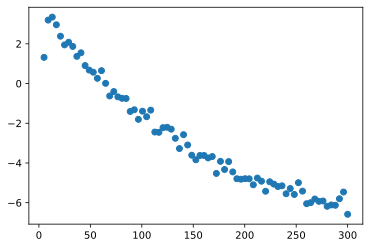

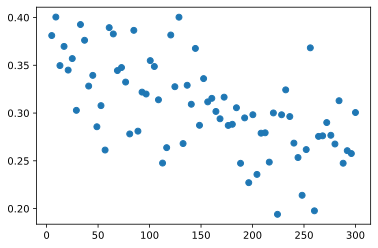

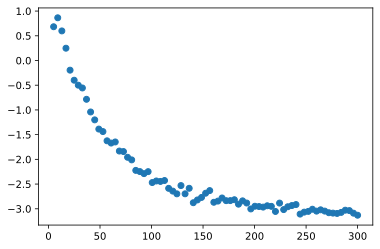

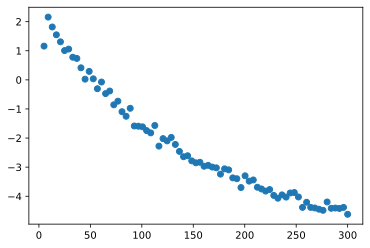

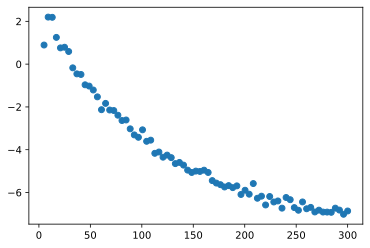

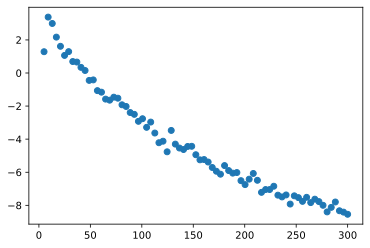

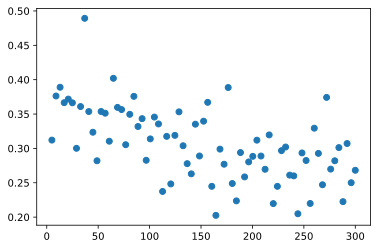

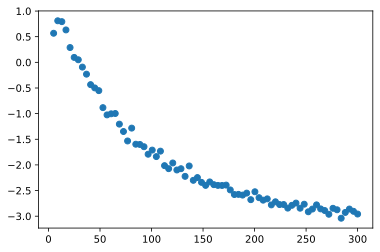

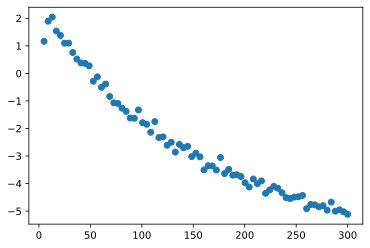

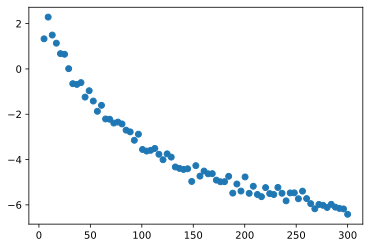

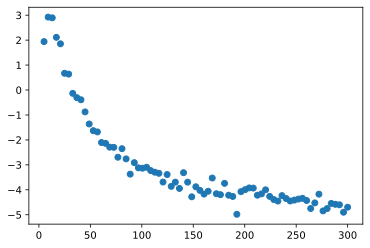

In [106]:
mod_es_data_v1_1 = []

for sample in tot_es_data_v1_1:
    trial_samp = []
    for sweep in sample:
        if (sweep[1] < sweep[-1]):
            sweep = np.negative(sweep)
        trial_samp.append(sweep)
    mod_es_data_v1_1.append(trial_samp)
    
for a in mod_es_data_v1_1:
    for b in a:
        plt.scatter(times_us_v1, b)
        plt.show()

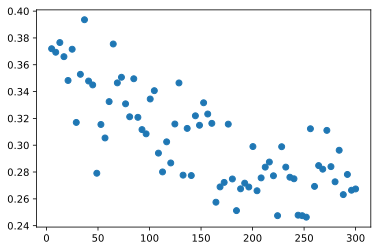

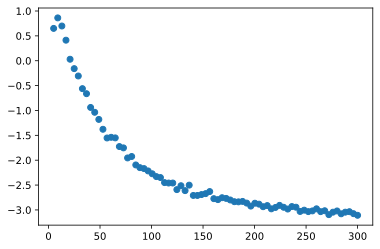

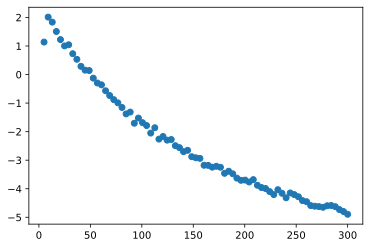

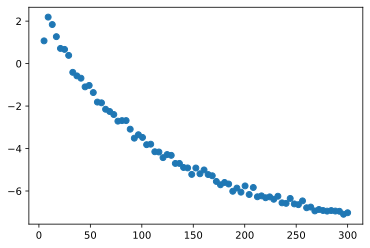

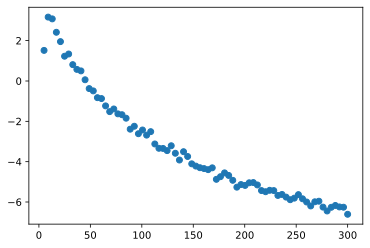

In [107]:
mod_avg_es_data_v1_1 = np.array([[0+0j] * len(times_us_v1) for i in range(len(amps_v1_1))])
for i in range(len(mod_es_data_v1_1)):
    mod_avg_es_data_v1_1 += np.array(mod_es_data_v1_1[i])
mod_avg_es_data_v1_1 = mod_avg_es_data_v1_1 / num_trials_v1

for i in mod_avg_es_data_v1_1:
    plt.scatter(times_us_v1, i)
    plt.show()

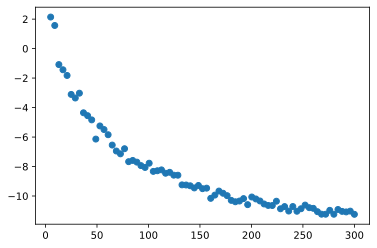

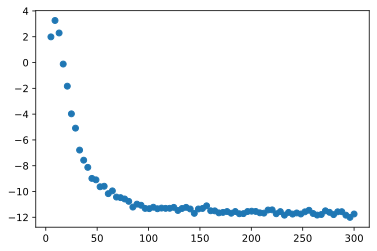

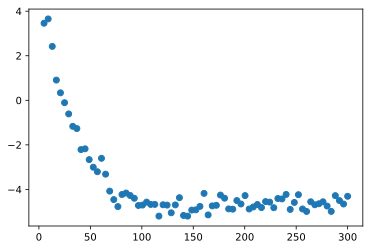

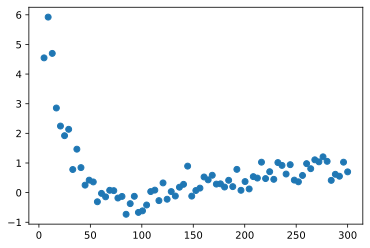

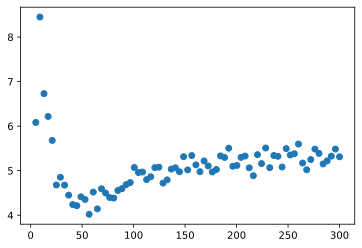

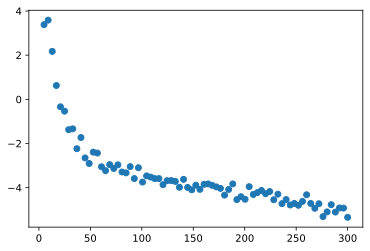

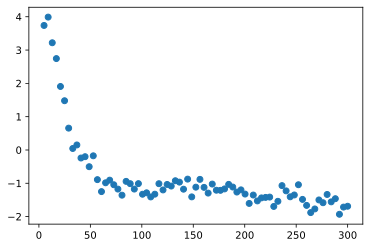

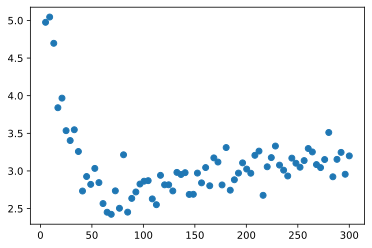

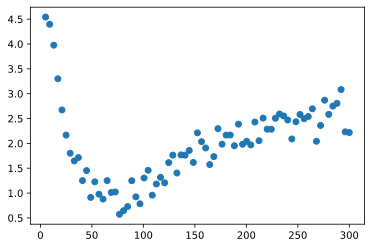

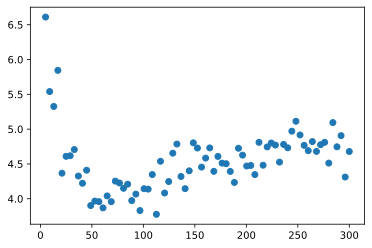

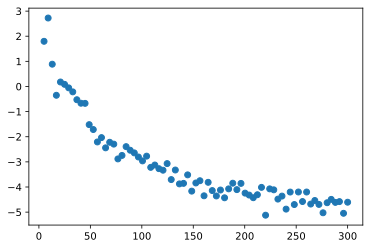

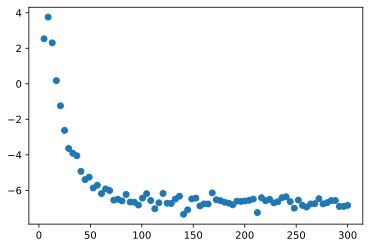

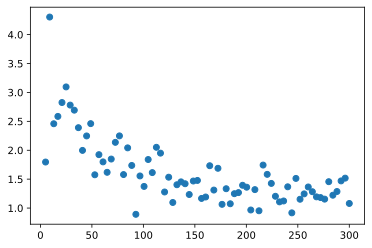

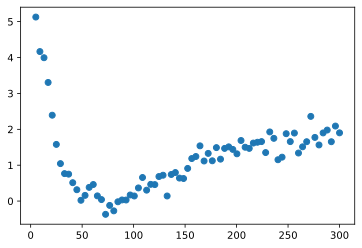

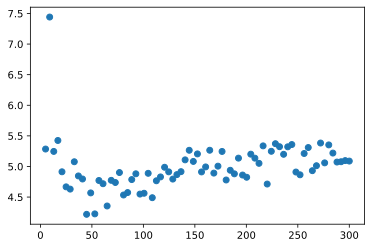

In [108]:
mod_es_data_v1_2 = []

for sample in tot_es_data_v1_2:
    trial_samp = []
    for sweep in sample:
        if (sweep[1] < sweep[-1]):
            sweep = np.negative(sweep)
        trial_samp.append(sweep)
    mod_es_data_v1_2.append(trial_samp)
    
for a in mod_es_data_v1_2:
    for b in a:
        plt.scatter(times_us_v1, b)
        plt.show()

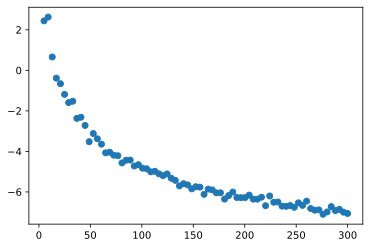

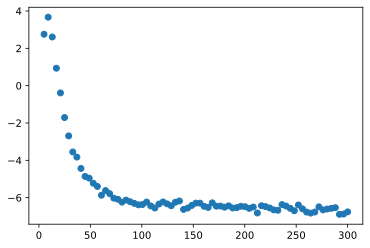

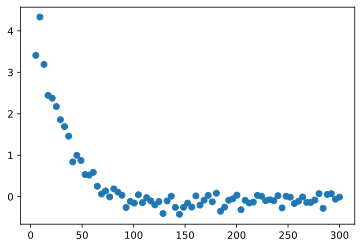

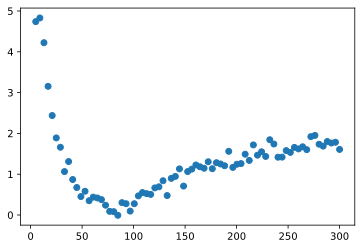

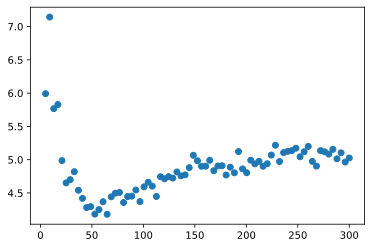

In [109]:
mod_avg_es_data_v1_2 = np.array([[0+0j] * len(times_us_v1) for i in range(len(amps_v1_1))])
for i in range(len(mod_es_data_v1_2)):
    mod_avg_es_data_v1_2 += np.array(mod_es_data_v1_2[i])
mod_avg_es_data_v1_2 = mod_avg_es_data_v1_2 / num_trials_v1

for i in mod_avg_es_data_v1_2:
    plt.scatter(times_us_v1, i)
    plt.show()

In [110]:
# combine averaged arrays of all data to get complete amplitude sweeps for both gs and es
mod_avg_gs_data_v1 = np.concatenate([mod_avg_gs_data_v1_1, mod_avg_gs_data_v1_2])
mod_avg_es_data_v1 = np.concatenate([mod_avg_es_data_v1_1, mod_avg_es_data_v1_2])

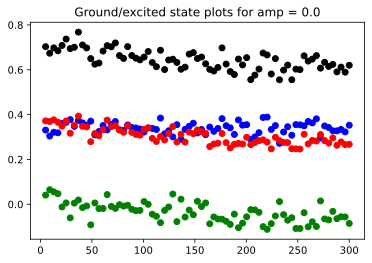

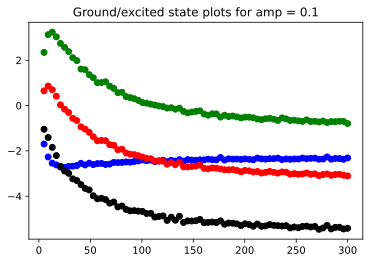

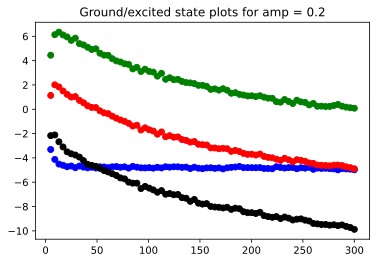

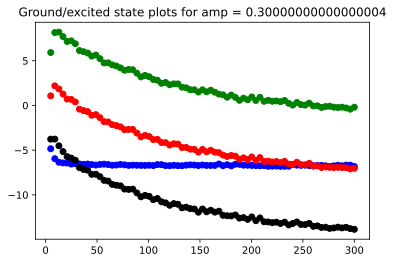

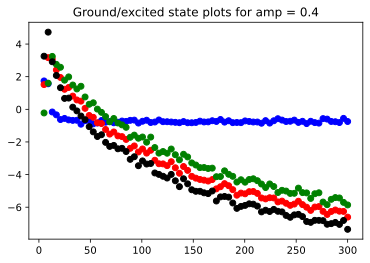

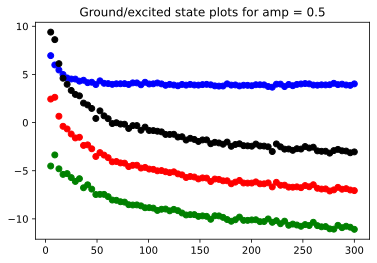

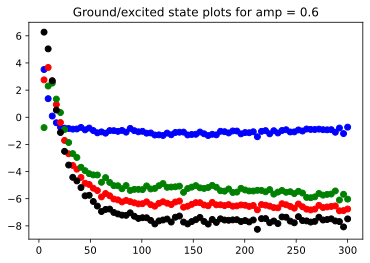

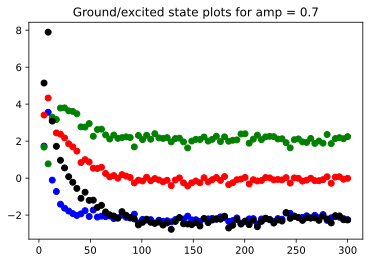

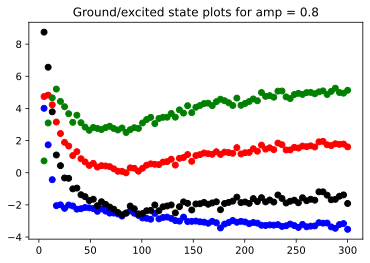

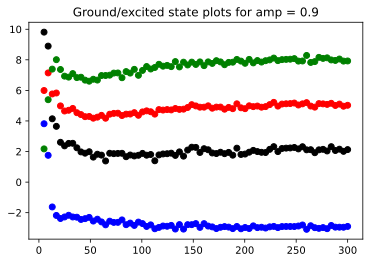

In [113]:
# record differences between the ground and excited state curves to determine qubit decay under a specific drive pulse
# not sure whether the 'difference curves' should correspond to excited curve + or - ground curve, based on orientation
diffs_reg = []
diffs_flipped = []

for i in range(len(mod_avg_gs_data_v1)):
    plt.scatter(times_us_v1, np.real(mod_avg_gs_data_v1[i]), color='blue')
    plt.scatter(times_us_v1, np.real(mod_avg_es_data_v1[i]), color='red')
    diff_reg = mod_avg_es_data_v1[i] - mod_avg_gs_data_v1[i]
    diff_flipped = mod_avg_es_data_v1[i] + mod_avg_gs_data_v1[i]
    plt.scatter(times_us_v1, np.real(diff_reg), color='green')
    plt.scatter(times_us_v1, np.real(diff_flipped), color='black')
    diffs_reg.append(diff_reg)
    diffs_flipped.append(diff_flipped)
    plt.title(f"Ground/excited state plots for amp = {amps_v1[i]}")
    plt.show()

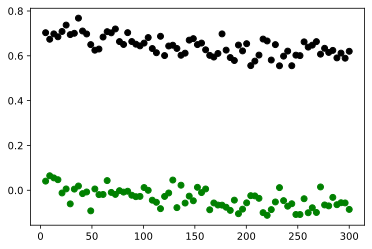

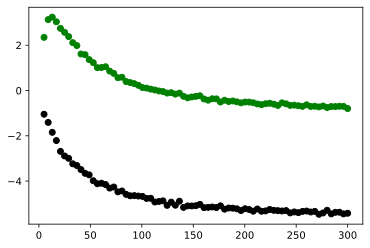

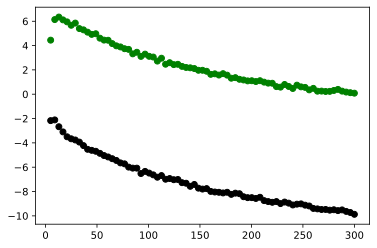

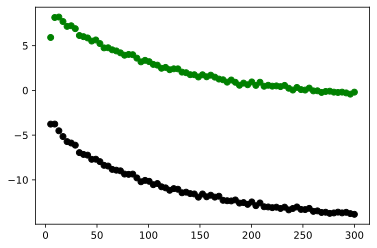

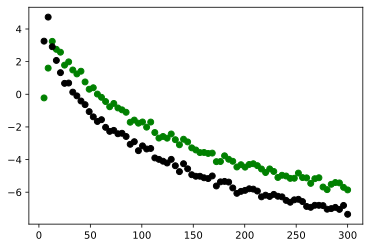

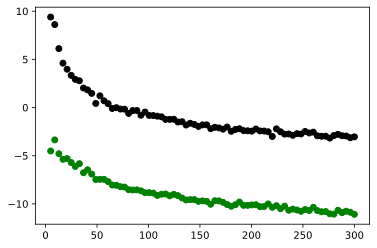

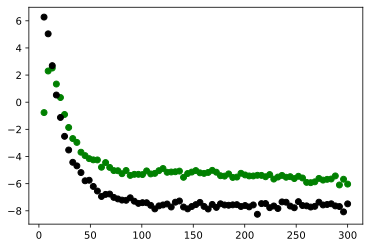

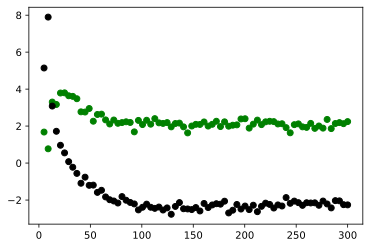

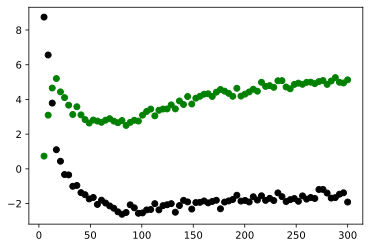

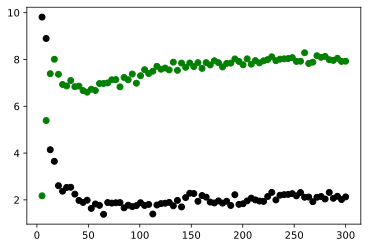

In [117]:
# plot only the 2 types of potential difference curves for better picture
for i in range(len(diffs_reg)):
    plt.scatter(times_us_v1, np.real(diffs_reg[i]), color='green')
    plt.scatter(times_us_v1, np.real(diffs_flipped[i]), color='black')
    plt.show()